In [1]:
import argparse
import time
import sys
import pickle
import seaborn as sns
import torch
import scvelo as scv
import scanpy
import scipy
import numpy as np
import seaborn as sns
import pandas as pd

from veloproj import *
from veloproj.model import leastsq_pt
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad',
                               '--model-name', 'scNT_model.cpt',
                               '--exp-name', 'CohAE_scNT',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("0", "15"), ("15", "30"), ("30", "60"), ("60", "120")]
k_cluster = "time"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
adata.obs['time'] = adata.obs.time.astype('category')
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
Filtered out 39141 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3066 × 2000
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


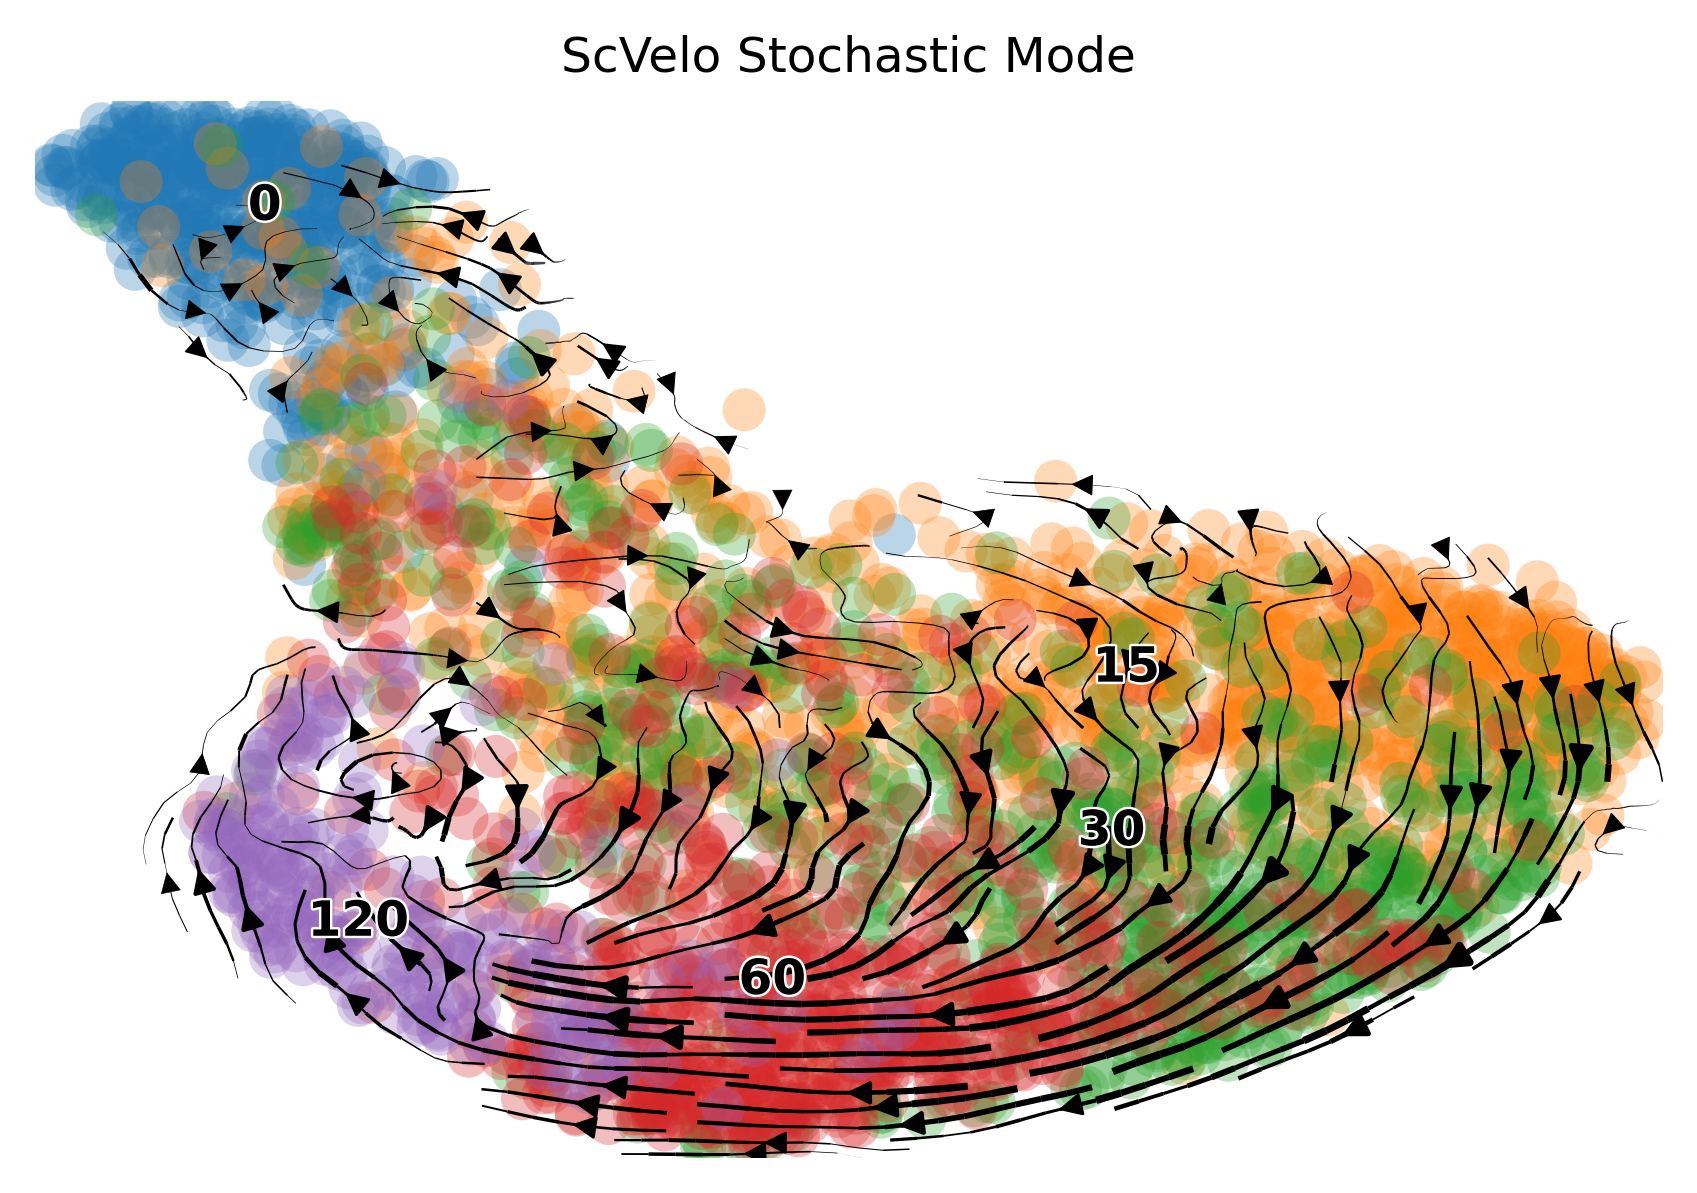

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.18048932, ('15', '30'): 0.18491264, ('30', '60'): 0.23308793, ('60', '120'): 0.26255766}
Total Mean: 0.21526187658309937
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.8822449, ('15', '30'): 0.8497038, ('30', '60'): 0.8860211, ('60', '120'): 0.9495534}
Total Mean: 0.8918807506561279
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.18838234782403288, ('15', '30'): 0.18308582228348033, ('30', '60'): 0.2605164292994082, ('60', '120'): 0.379863461349844}
Total Mean: 0.25296201518919137
# In-cluster Coherence
{'0': 0.9150228, '120': 0.96112573, '15': 0.86938184, '30': 0.8746792, '60': 0.9513404}
Total Mean: 0.9143099784851074
# In-cluster Confidence
{'0': 0.5655496921515305, '120': 0.5211484991385048, '15': 0.5152809521446677, '30': 0.5523806887060942, '60': 0.6307199556375143}
Total Mean: 0.5570159575556624


In [6]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['time'],dpi=350,
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

recovering dynamics (using 10/40 cores)


  0%|          | 0/2000 [00:00<?, ?gene/s]

    finished (0:01:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:09) --> added 
    'dyn_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'dyn_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'dyn_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scNT_dynamical.png


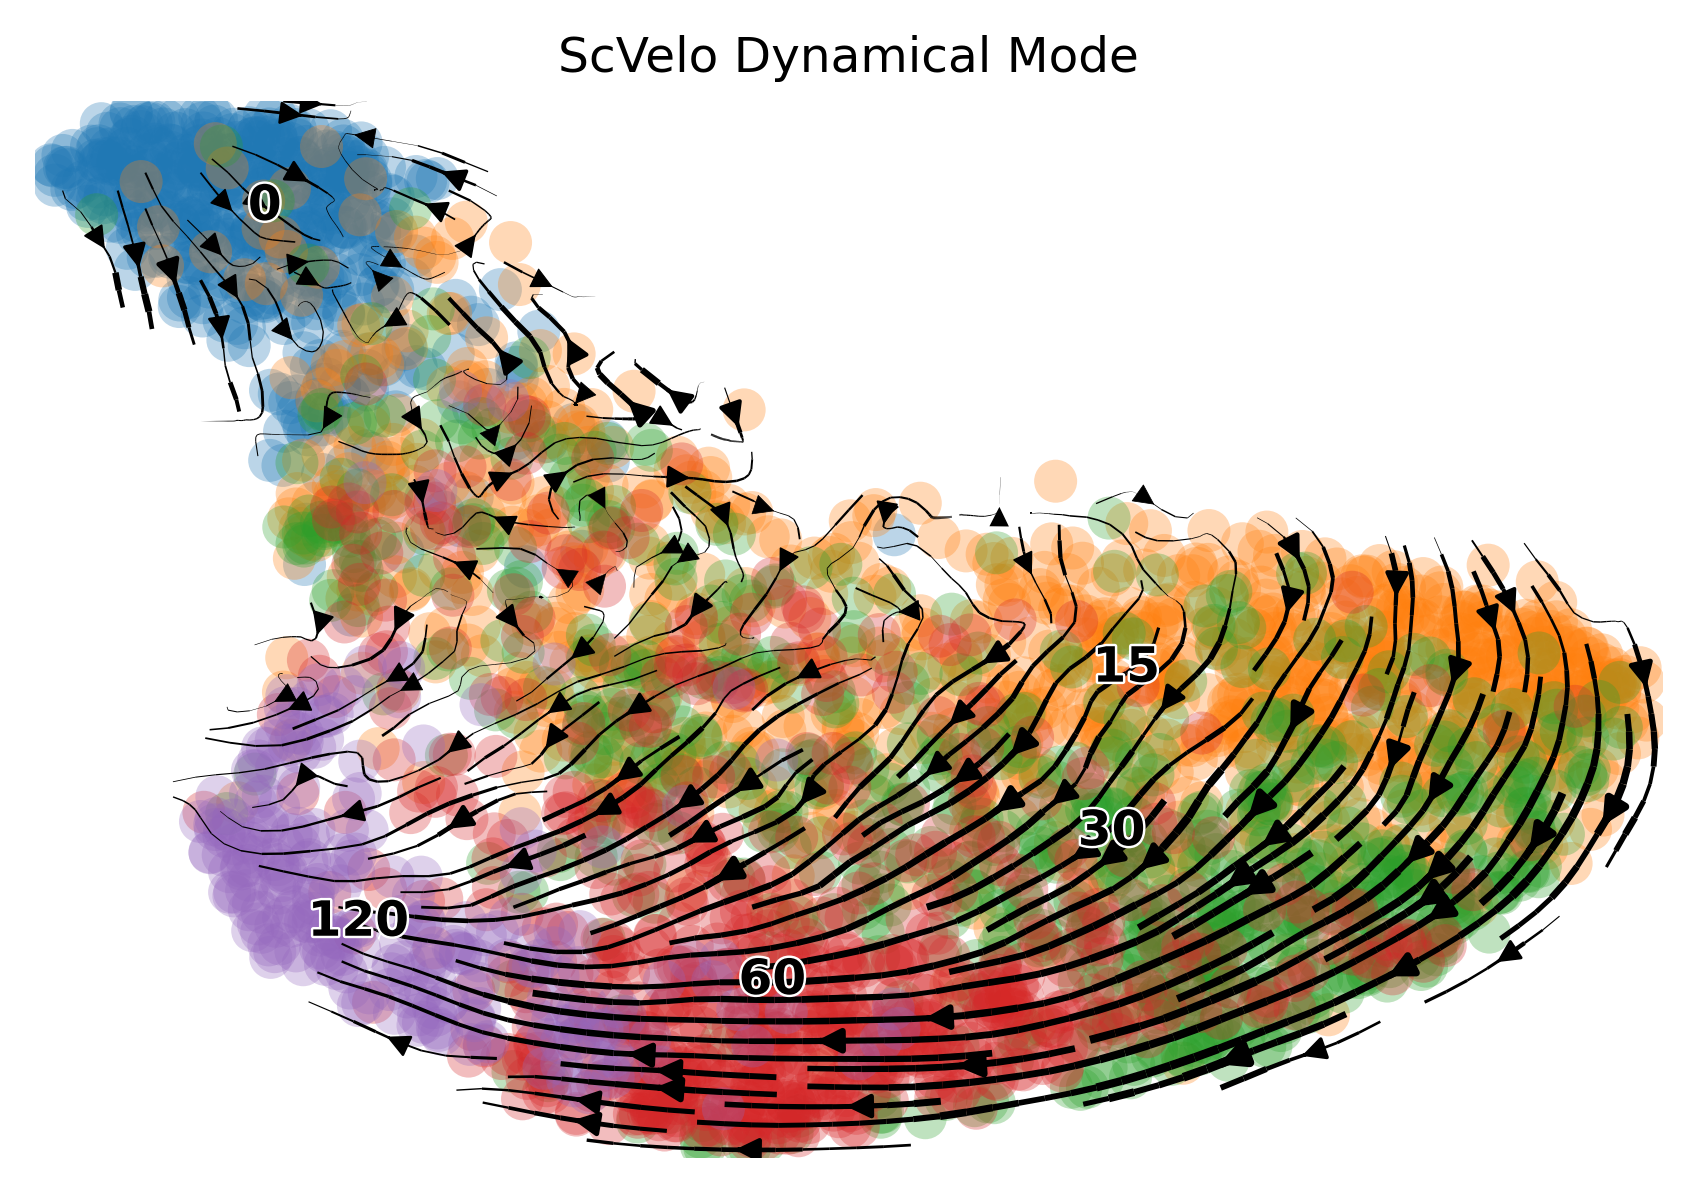

--> added 'dyn_velocity_length' (adata.obs)
--> added 'dyn_velocity_confidence' (adata.obs)
--> added 'dyn_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.0814504, ('15', '30'): 0.12693425, ('30', '60'): 0.24232015, ('60', '120'): 0.2673731}
Total Mean: 0.17951947450637817
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9390082353305111, ('15', '30'): 0.9312143133232011, ('30', '60'): 0.9305457797252532, ('60', '120'): 0.9329098858774637}
Total Mean: 0.9334195535641073
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.1958731252618775, ('15', '30'): 0.2644599409648481, ('30', '60'): 0.2918914137286693, ('60', '120'): 0.4489427831528537}
Total Mean: 0.30029181577706215
# In-cluster Coherence
{'0': 0.9594777760086919, '120': 0.961387319661866, '15': 0.942952826649098, '30': 0.9445504260863166, '60': 0.9498948797444072}
Total Mean: 0.951652645630076
# In-cluster Confidence
{'0': 0.7844772998949889, '120': 0.813595

In [7]:
scv.tl.recover_dynamics(adata, use_raw=False, var_names="all", n_jobs=10)
scv.tl.velocity(adata, vkey='dyn_velocity', mode='dynamical', use_raw=False)
scv.tl.velocity_graph(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="dyn_velocity", color=[k_cluster], basis='X_umap', dpi=350,
                                title='ScVelo Dynamical Mode', save="scNT_dynamical.png")
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
sel = ~np.isnan(adata.var.fit_likelihood)
exp_metrics['dyn_mode'] = evaluate(adata[:, sel], cluster_edges, k_cluster, "dyn_velocity", 'X_umap')

In [8]:
with open("dyn_scNT.pkl", 'wb') as ofile:
    pickle.dump(exp_metrics, ofile)

In [9]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


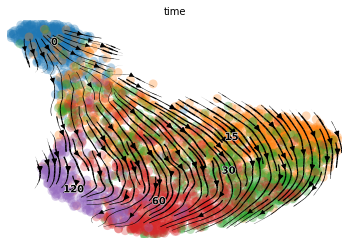

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.73141396, ('15', '30'): 0.74388045, ('30', '60'): 0.5976444, ('60', '120'): 0.6841231}
Total Mean: 0.6892654299736023
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9999732, ('15', '30'): 0.99997705, ('30', '60'): 0.99997354, ('60', '120'): 0.9999702}
Total Mean: 0.999973475933075
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.6831897186309368, ('15', '30'): 0.439300280871956, ('30', '60'): 0.2917442673512549, ('60', '120'): 0.2066396099135494}
Total Mean: 0.4052184691919243
# In-cluster Coherence
{'0': 0.9999742, '120': 0.99998224, '15': 0.99998033, '30': 0.99998057, '60': 0.9999773}
Total Mean: 0.9999788403511047
# In-cluster Confidence
{'0': 0.9999716519242698, '120': 0.9999748767609615, '15': 0.9999768809498293, '30': 0.999976606959262, '60': 0.9999733513988748}
Total Mean: 0.9999746735986396


In [10]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    new_v_key = "new_velocity"
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src, new_v_key=new_v_key)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.tl.velocity_confidence(adata, vkey="new_velocity")
    scv.pl.velocity_embedding_stream(adata, vkey='new_velocity', basis='X_umap' , color='time')
    evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    return x, u, s, v
    
x, u, s, v  = exp(adata, exp_metrics)

In [11]:
sel_0, sel_15, sel_30 = adata.obs.time == '0', adata.obs.time == "15", adata.obs.time == "30"
sel_60, sel_120 = adata.obs.time == "60", adata.obs.time == "120"

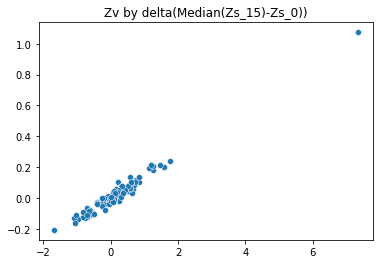

In [12]:
ax = sns.scatterplot(np.median(v[sel_0], axis=0), np.median(np.median(s[sel_15], axis=0) - s[sel_0], axis=0))
plt.title("Zv by delta(Median(Zs_15)-Zs_0))")
ax.get_figure().savefig(f"./figures/{args.exp_name}_low_dim_v_by_delta_s.png",dpi=350)

In [13]:
import hilearn
def abline(x_vals, y_vals):
    hilearn.corr_plot(x_vals, y_vals)

(100,) (100,)
87.8% are consistent


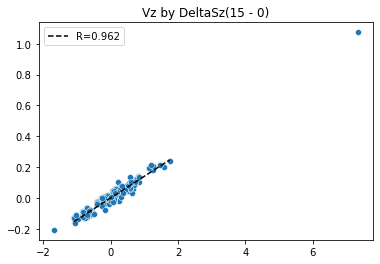

In [14]:
sel = np.ones(args.z_dim, dtype=np.bool)
median_Vu = np.median(v[sel_0], axis=0)
median_deltaSu = np.median(np.median(s[sel_15], axis=0) - s[sel_0], axis=0)

df = pd.DataFrame()
df['Vz'] = median_Vu
df['DeltaSz'] = median_deltaSu
df['latent_dim'] = list(range(args.z_dim))

print(median_Vu.shape, median_deltaSu.shape)
max_thred, min_thred = np.percentile(median_Vu, 99), np.percentile(median_Vu, 1)
sel = sel & (median_Vu < max_thred) & (median_Vu > min_thred)

max_thred, min_thred = np.percentile(median_deltaSu, 99), np.percentile(median_deltaSu, 1)
sel = sel & (median_deltaSu < max_thred) & (median_deltaSu > min_thred)


consist = len([1 for _v, _ds in zip(median_Vu[sel], median_deltaSu[sel]) if _v * _ds > 0])
contradict = len([1 for _v, _ds in zip(median_Vu[sel], median_deltaSu[sel]) if _v * _ds < 0])
print("{:.1%} are consistent".format(consist / (consist + contradict)))

abline(median_Vu[sel], median_deltaSu[sel])
ax = sns.scatterplot(data=df, x=median_Vu, y=median_deltaSu)

plt.title("Vz by DeltaSz(15 - 0)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_vz_by_dSz.png", dpi=350)


(2000,) (2000,)
50.7% are opposite


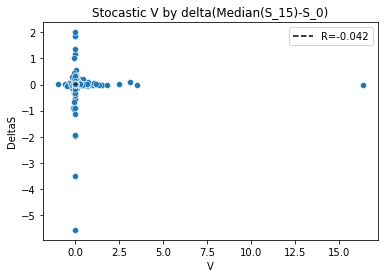

In [15]:
sel = np.ones(adata.X.shape[1], dtype=np.bool)
median_stc = np.median(adata.layers['stc_velocity'][sel_0], axis=0)
median_deltaS = np.median(np.median(spliced[sel_15], axis=0) - spliced[sel_0], axis=0)

print(median_stc.shape, median_deltaS.shape)
max_thred, min_thred = np.percentile(median_stc, 90), np.percentile(median_stc, 10)
sel = sel & (median_stc < max_thred) & (median_stc > min_thred)

max_thred, min_thred = np.percentile(median_deltaS, 90), np.percentile(median_deltaS, 10)
sel = sel & (median_deltaS < max_thred) & (median_deltaS > min_thred)

consist = len([1 for _v, _ds in zip(median_stc[sel], median_deltaS[sel]) if _v * _ds > 0])
contradict = len([1 for _v, _ds in zip(median_stc[sel], median_deltaS[sel]) if _v * _ds < 0])
print("{:.1%} are opposite".format(contradict /(contradict + consist)))

abline(median_stc[sel], median_deltaS[sel])

df = pd.DataFrame()
df['V'] = median_stc
df['DeltaS'] = median_deltaS

ax = sns.scatterplot(data=df, x="V", y='DeltaS')
plt.title("Stocastic V by delta(Median(S_15)-S_0)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_stc_v_by_delta_s_full_data.png",dpi=350)

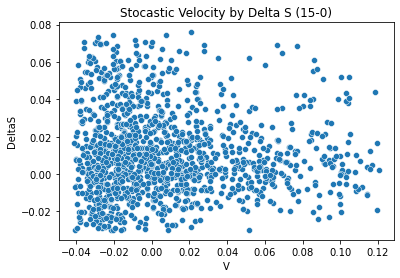

In [16]:
ax = sns.scatterplot(data=df.iloc[sel], x="V", y='DeltaS')
plt.legend([],[], frameon=False)
plt.title("Stocastic Velocity by Delta S (15-0)")
ax.get_figure().savefig(f"./figures/{args.exp_name}_stc_v_by_delta_s.png",dpi=350)

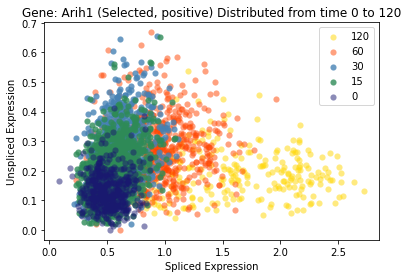

In [17]:
gene_idx = 1642
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.scatter(spliced[sel_120, gene_idx], unspliced[sel_120, gene_idx], color='gold', alpha=.5, linewidths=0.1, label="120")
ax.scatter(spliced[sel_60, gene_idx], unspliced[sel_60, gene_idx], color='orangered', alpha=.5, linewidths=0.1, label="60")
ax.scatter(spliced[sel_30, gene_idx], unspliced[sel_30, gene_idx], color='steelblue', alpha=.8, linewidths=0.1, label="30")
ax.scatter(spliced[sel_15, gene_idx], unspliced[sel_15, gene_idx], color='seagreen', alpha=.8, linewidths=0.1, label="15")
ax.scatter(spliced[sel_0, gene_idx], unspliced[sel_0, gene_idx], color='midnightblue', alpha=.5, linewidths=0.1, label="0")

ax.legend()
ax.set_title(f"Gene: {adata.var.gene_short_name[gene_idx]} (Selected, positive) Distributed from time 0 to 120")
ax.set_xlabel('Spliced Expression')
ax.set_ylabel('Unspliced Expression')
fig.savefig(f"./figures/{args.exp_name}_GeneArih1SvsU.png", dpi=350)
#  plt.title("(Sz, Uz) of Z({}) with Highest Spearman R ({}) against Pseudotime".format(max_Zs, np.max(corrs)))

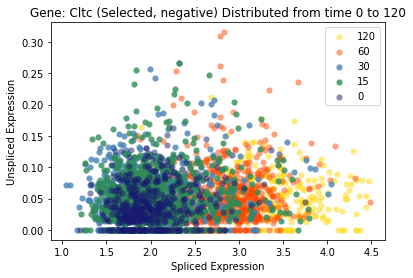

In [18]:
gene_idx = 921

fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.scatter(spliced[sel_120, gene_idx], unspliced[sel_120, gene_idx], color='gold', alpha=.5, linewidths=0.1, label="120")
ax.scatter(spliced[sel_60, gene_idx], unspliced[sel_60, gene_idx], color='orangered', alpha=.5, linewidths=0.1, label="60")
ax.scatter(spliced[sel_30, gene_idx], unspliced[sel_30, gene_idx], color='steelblue', alpha=.8, linewidths=0.1, label="30")
ax.scatter(spliced[sel_15, gene_idx], unspliced[sel_15, gene_idx], color='seagreen', alpha=.8, linewidths=0.1, label="15")
ax.scatter(spliced[sel_0, gene_idx], unspliced[sel_0, gene_idx], color='midnightblue', alpha=.5, linewidths=0.1, label="0")

ax.legend()

ax.legend()
ax.set_title(f"Gene: {adata.var.gene_short_name[gene_idx]} (Selected, negative) Distributed from time 0 to 120")
ax.set_xlabel('Spliced Expression')
ax.set_ylabel('Unspliced Expression')
fig.savefig(f"./figures/{args.exp_name}_GeneCltcSvsU.png", dpi=350)